# Traditional CNN auf den preprocessed Event-Features
Dieses Notebook nutzt die bereits gespeicherten Daten aus `data/processed` (aus `preprocess_data.py`).
Wir:
- laden `X_train/X_val/X_test` und `y_*` (One-Hot Labels)
- rekonstruieren daraus Bilder mit 2 Kanälen (pos/neg Time-Surface)
- visualisieren ein paar Beispiele
- trainieren ein kleines CNN und testen es auf dem Testset.

In [3]:
# Setup / Imports
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Damit `models/...` importierbar ist (Notebook liegt in notebooks/traditionalNN/)
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../..').resolve()))

from models.preprocessing import load_preprocessed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [4]:
# Daten laden
data_dir = Path('../../data/processed')
splits, class_names = load_preprocessed(data_dir)
X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

print('Class names:', class_names)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)

n_features = X_train.shape[1]
n_classes = y_train.shape[1]
print('n_features:', n_features)
print('n_classes :', n_classes)

# Wir rekonstruieren ein Bild mit 2 Kanälen aus dem Feature-Vektor.
# In models/preprocessing.py: time_surface -> concat([surface_pos.flatten(), surface_neg.flatten()])
if n_features % 2 != 0:
    raise ValueError(f'Erwarte gerade Feature-Anzahl (pos+neg), bekommen: {n_features}')

hw = n_features // 2
known_shapes = {
    640 * 480: (480, 640),
    64 * 48: (48, 64),
    320 * 240: (240, 320),
}
if hw not in known_shapes:
    raise ValueError(
        f'Unbekannte Bildgröße: hw={hw}. '
        'Passe known_shapes an oder ändere das Preprocessing so, dass width/height bekannt sind.'
    )
H, W = known_shapes[hw]
print('Rekonstruiertes Bildformat:', (H, W, 2))

Loaded train: X=(9, 6144), y=(9, 10)
Loaded val: X=(3, 6144), y=(3, 10)
Loaded test: X=(2, 6144), y=(2, 10)
Loaded class names: ['benjamin', 'christian', 'felix', 'jonas', 'leon', 'mark', 'marvin', 'ohman', 'veronica', 'yannes']
Class names: ['benjamin', 'christian', 'felix', 'jonas', 'leon', 'mark', 'marvin', 'ohman', 'veronica', 'yannes']
X_train: (9, 6144) y_train: (9, 10)
X_val:   (3, 6144) y_val:   (3, 10)
X_test:  (2, 6144) y_test:  (2, 10)
n_features: 6144
n_classes : 10
Rekonstruiertes Bildformat: (48, 64, 2)


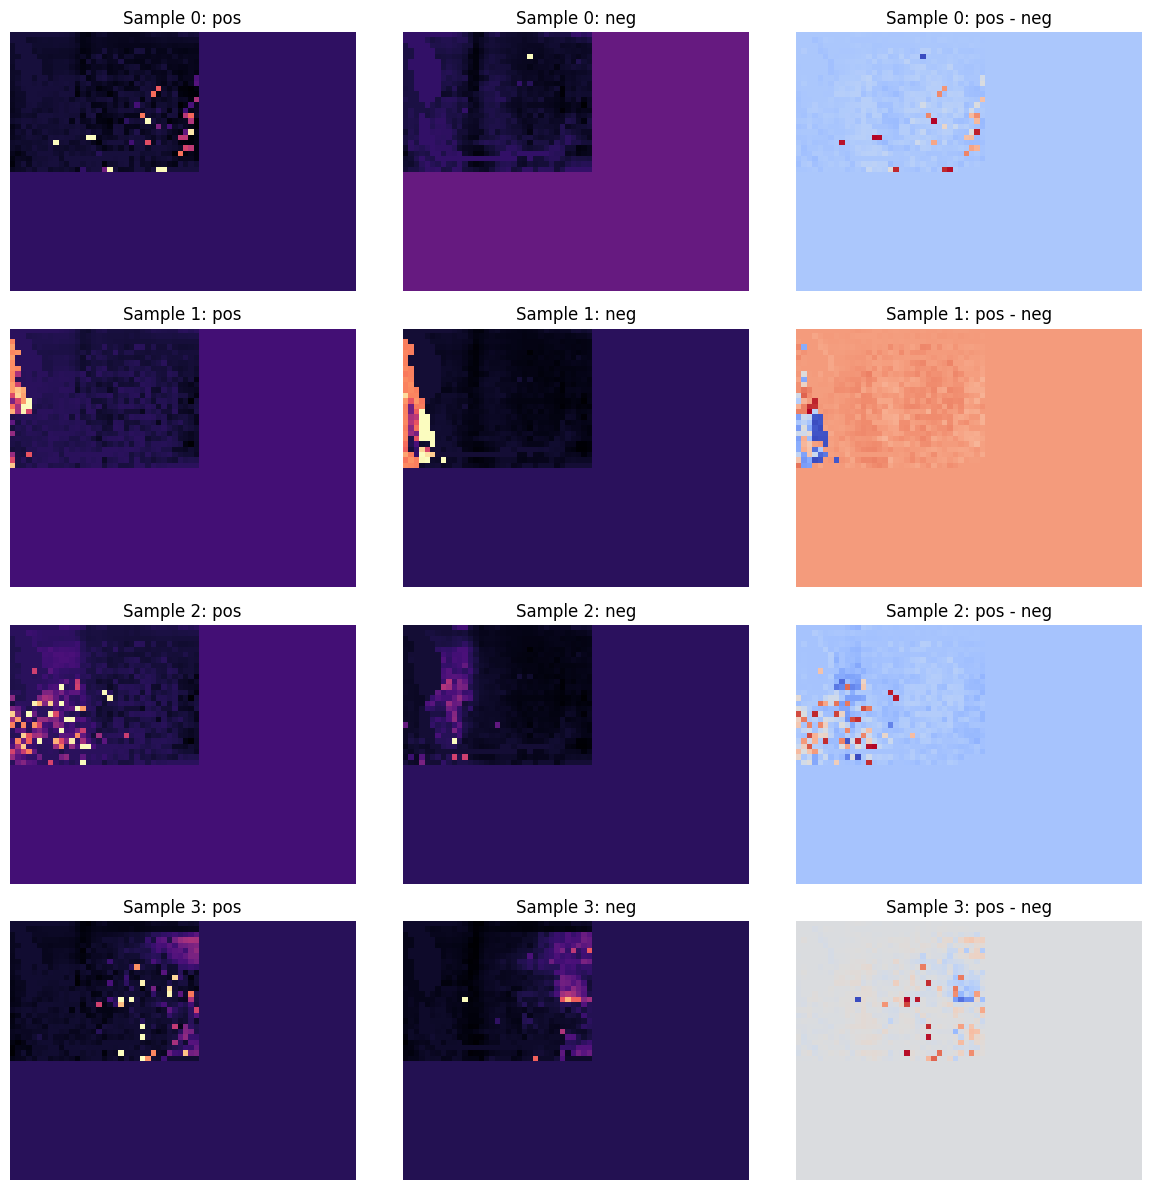

In [5]:
# Kurze Visualisierung (ein paar Samples)
def vector_to_image_np(x_vec: np.ndarray, H: int, W: int) -> np.ndarray:
    x_vec = np.asarray(x_vec)
    hw = H * W
    pos = x_vec[:hw].reshape(H, W)
    neg = x_vec[hw:hw*2].reshape(H, W)
    img = np.stack([pos, neg], axis=-1)  # (H, W, 2)
    return img

n_show = min(4, len(X_train))
fig, axes = plt.subplots(n_show, 3, figsize=(12, 3 * n_show))
if n_show == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(n_show):
    img = vector_to_image_np(X_train[i], H, W)
    pos = img[..., 0]
    neg = img[..., 1]
    diff = pos - neg
    axes[i, 0].imshow(pos, cmap='magma')
    axes[i, 0].set_title(f'Sample {i}: pos')
    axes[i, 1].imshow(neg, cmap='magma')
    axes[i, 1].set_title(f'Sample {i}: neg')
    axes[i, 2].imshow(diff, cmap='coolwarm')
    axes[i, 2].set_title(f'Sample {i}: pos - neg')
    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# tf.data Pipeline: Vektor -> (H,W,2) ohne große Copies
AUTOTUNE = tf.data.AUTOTUNE

def to_image_tf(x_vec, y):
    x_vec = tf.cast(x_vec, tf.float32)
    hw = H * W
    pos = tf.reshape(x_vec[:hw], (H, W, 1))
    neg = tf.reshape(x_vec[hw:hw*2], (H, W, 1))
    img = tf.concat([pos, neg], axis=-1)  # (H, W, 2)
    y = tf.cast(y, tf.float32)
    return img, y

batch_size = 16
ds_train = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(min(len(X_train), 2000), seed=42, reshuffle_each_iteration=True)
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_test = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Sanity-check: ein Batch
x_b, y_b = next(iter(ds_train))
print('Batch X:', x_b.shape, 'Batch y:', y_b.shape)

2025-12-28 10:26:54.562399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-12-28 10:26:54.562464: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-28 10:26:54.562495: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (framework-yannes): /proc/driver/nvidia/version does not exist
2025-12-28 10:26:54.563076: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Batch X: (9, 48, 64, 2) Batch y: (9, 10)


In [7]:
# CNN Modell
# (Die Bilder sind groß. Damit Training schneller geht, verkleinern wir im Modell.)
target_h, target_w = 120, 160

model = keras.Sequential([
    layers.Input(shape=(H, W, 2)),
    layers.Resizing(target_h, target_w),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 120, 160, 2)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 16)      304       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 40, 64)        1

In [10]:
# Training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=callbacks,
)

Epoch 1/15
1/1 [==============================] - 0s 113ms/step - loss: 2.2838 - accuracy: 0.3333 - val_loss: 2.3010 - val_accuracy: 0.3333
Epoch 2/15
1/1 [==============================] - 0s 107ms/step - loss: 2.2672 - accuracy: 0.3333 - val_loss: 2.3017 - val_accuracy: 0.3333
Epoch 3/15
1/1 [==============================] - 0s 96ms/step - loss: 2.2478 - accuracy: 0.3333 - val_loss: 2.3005 - val_accuracy: 0.3333
Epoch 4/15
1/1 [==============================] - 0s 113ms/step - loss: 2.2257 - accuracy: 0.3333 - val_loss: 2.2972 - val_accuracy: 0.3333


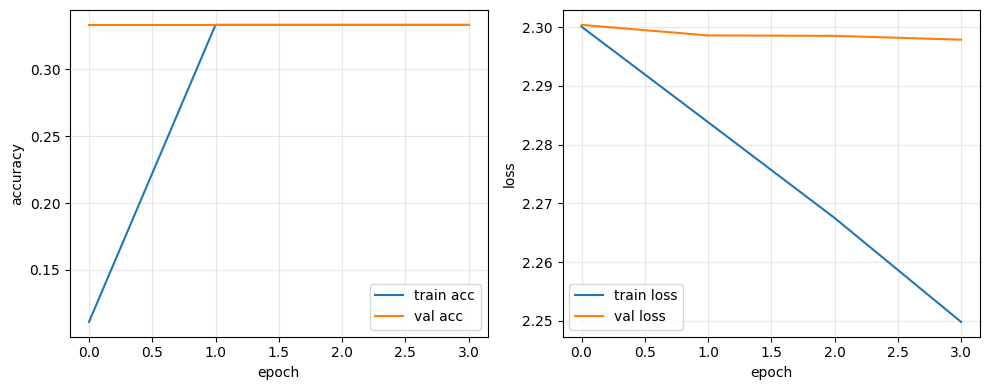

In [9]:
# Training-Kurven (kurz)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train acc')
plt.plot(history.history.get('val_accuracy', []), label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.grid(alpha=0.3)
plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train loss')
plt.plot(history.history.get('val_loss', []), label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Testing / Evaluation am Testset
test_loss, test_acc = model.evaluate(ds_test, verbose=1)
print(f'Test loss: {test_loss:.4f}')
print(f'Test acc : {test_acc:.4f}')

# (Optional) ein paar Vorhersagen anzeigen
n_pred = 5
for batch_x, batch_y in ds_test.take(1):
    probs = model.predict(batch_x, verbose=0)
    y_true = tf.argmax(batch_y, axis=1).numpy()
    y_pred = tf.argmax(probs, axis=1).numpy()
    for i in range(min(n_pred, len(y_true))):
        print(f'Sample {i}: true={class_names[y_true[i]]}, pred={class_names[y_pred[i]]}')

1/1 [==============================] - 0s 77ms/step - loss: 2.2820 - accuracy: 0.5000
Test loss: 2.2820
Test acc : 0.5000
Sample 0: true=marvin, pred=marvin
Sample 1: true=ohman, pred=marvin
